# 6. Frame Selected Discriminality and ICC

In [3]:
from src import *

In [4]:
import pingouin

## Description

We evaluate frame selected's discriminality and ICC values. 

GOAL: Compute frame selected's discriminality and ICC values. 

## Table of Contents
- [Frame selected (by 3FA) and discrim / ICC](#3fa)

In [5]:
D = lambda x,y: ((x-y)**2).sum(axis=1)
distance = lambda x,y: 1 - pearson_correlation(x,y)

def compute_discriminality(samples):
    """
    Compute Value of discriminality within a distance/similarity matrix (2d inputs)
    """
    
    nb_smp = samples.shape[0]
    dist_mat = np.zeros((nb_smp,nb_smp))

    for k in range(nb_smp):
        for j in range(nb_smp):
            dist_mat[k,j] = distance(samples[k],samples[j])

    discrim = []
    for k in range(nb_smp//2):
        sample_size = nb_smp-1 # remove 1 for identity
        discrim.append(np.sum(dist_mat[k][30+k] <= dist_mat[k])/sample_size)
    
    return np.mean(discrim)

<a class="anchor" id="3fa"></a>
## Frame selected (by 3FA) and discrim / ICC 

In [15]:
s5 = [(s,s+5) for s in range(0,101,5) if (s+5 <= 100)]
s10 = [(s,s+10) for s in range(0,101,10) if (s+10 <= 100)]
s20 = [(s,s+20) for s in range(0,101,20) if (s+20 <= 100)]
s25 = [(s,s+25) for s in range(0,101,25) if (s+25 <= 100)]
s33 = [(0,33), (33,66), (66,100)]
s50 = [(0,50), (50,100)]
thresholds = s5 + s10 + s20 + s25 + s33 + s50

In [16]:
# Params
embedding  = "dm" # diffusion map
aff_kernel = "pearson" #affinity matrix kernel
align_meth = "procrustes"
n_iter     = 10 # procrustes align number of iteration
nb_comp    = 3
rs         = 99

#### Load frame selected and full movie gradients (individual level)

In [17]:
total_series = load('./data/fmri_414_series.pkl')
f_series = load('./resources/threshed_series/fa_global_treshed_series.pkl')

if 'Rest' in f_series: del fselect_series['Rest']
if 'Rest' in total_series: del total_series['Rest']

In [18]:
def persubject_grad(series, S):
    ## Warn: global variables here don't use it elsewhere
    fselect = {_id:[] for _id in series['Sintel'].keys()}
    # array swap
    for mname in S:
        tmp_dict = series[mname]

        for _id in tmp_dict:
            tmp_series = tmp_dict[_id]
            fselect[_id].append(tmp_series)

    # all movies gradients compute
    gradients = {}
    for _id in fselect:
        tmp_series = np.concatenate(fselect[_id])
        fc = FC(tmp_series)
        g = GradientMaps(n_components=nb_comp, approach=embedding, 
                                kernel=aff_kernel, random_state=rs)
        g.fit(fc)
        grad = g.gradients_

        fscore = D(grad.mean(axis=0), grad)
        gradients[_id] = fscore

    return gradients

def multiple_icc(test,retest):
    # test and retest multiple times along input arrays
    # test and retest are of format dict('target1': 1darray, 'target2': 1darray ...)
    icc_array = []
    n_iter = test[next(iter(test))].shape[0]
    for idx in range(n_iter):
        df = {'type': [], 'id': [], 'fscore': []}

        for _id in test.keys():
            df['id'] += [int(_id[1:])]
            df['fscore'] += [test[_id][idx]]
            df['type'] += ['test']

            df['id'] += [int(_id[1:])]
            df['fscore'] += [retest[_id][idx]]
            df['type'] += ['retest']

        df = pd.DataFrame.from_dict(df)

        icc = pingouin.intraclass_corr(data=df, targets='id', raters='type', ratings='fscore')
        icc_array.append(np.round(list(icc['ICC']),3)[2])
    
    return icc_array

#### Test-Retest classes

In [19]:
set1 = list(total_series.keys())[:len(total_series)//2]
set2 = list(total_series.keys())[len(total_series)//2:]

print(set1)
print(set2)

['ToClaireFromSonny', 'TheSecretNumber', 'Chatter', 'LessonLearned', 'Payload', 'AfterTheRain', 'Superhero']
['Sintel', 'TearsOfSteel', 'BetweenViewing', 'BigBuckBunny', 'YouAgain', 'Spaceman', 'FirstBite']


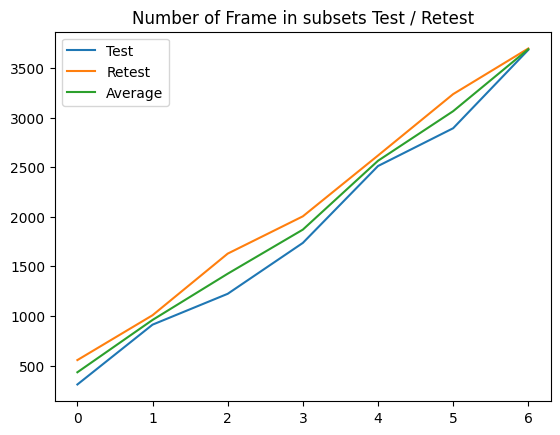

In [20]:
avg = np.cumsum([total_series[s]['S27'].shape[0] for s in set1]) + np.cumsum([total_series[s]['S27'].shape[0] for s in set2])
avg = avg/2
plt.plot(np.cumsum([total_series[s]['S27'].shape[0] for s in set1]), label='Test')
plt.plot(np.cumsum([total_series[s]['S27'].shape[0] for s in set2]), label='Retest')
plt.plot(avg, label='Average')
plt.title('Number of Frame in subsets Test / Retest')
plt.legend()

### Compute ICC across ID using as class the test or retest 

In [16]:
per_fa = {}
for fa_nb in range(3):
    icc_bounds = {}
    for bound in tqdm(thresholds):
        fselected_series = f_series[fa_nb][bound]

        step_array = []
        for k in range(len(set1), len(set1)+1):
            # Grouping test-retest
            fselect1_gradients = persubject_grad(fselected_series,set1[:k])
            fselect2_gradients = persubject_grad(fselected_series,set2[:k])

            icc_array = multiple_icc(fselect1_gradients, fselect2_gradients)
            step_array.append(icc_array)

        icc_bounds[bound] = step_array
    per_fa[fa_nb] = icc_bounds

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

In [ ]:
step_iccfull = []
for k in range(1,len(set1)+1):
    # Grouping test-retest
    ftotal1_gradients = persubject_grad(total_series,set1[:k])
    ftotal2_gradients = persubject_grad(total_series,set2[:k])
    
    icc_fullarray = multiple_icc(ftotal1_gradients, ftotal2_gradients)
    step_iccfull.append(icc_fullarray)

In [21]:
per_fa = load('./resources/test_retest_logs/icc_score.pkl')
step_iccfull = load('./resources/test_retest_logs/fullmovie_icc.pkl')

icc_bounds = np.asarray([per_fa[2][bound][-1] for bound in s25])
movie_icc = step_iccfull[-1]

#### Visualize results

/tmp/ipykernel_169353/4150652693.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[r,c].set_xticklabels(np.arange(0,8), fontsize=16)
/tmp/ipykernel_169353/4150652693.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[r,c].set_yticklabels(np.arange(1,9)/10,fontsize=16)


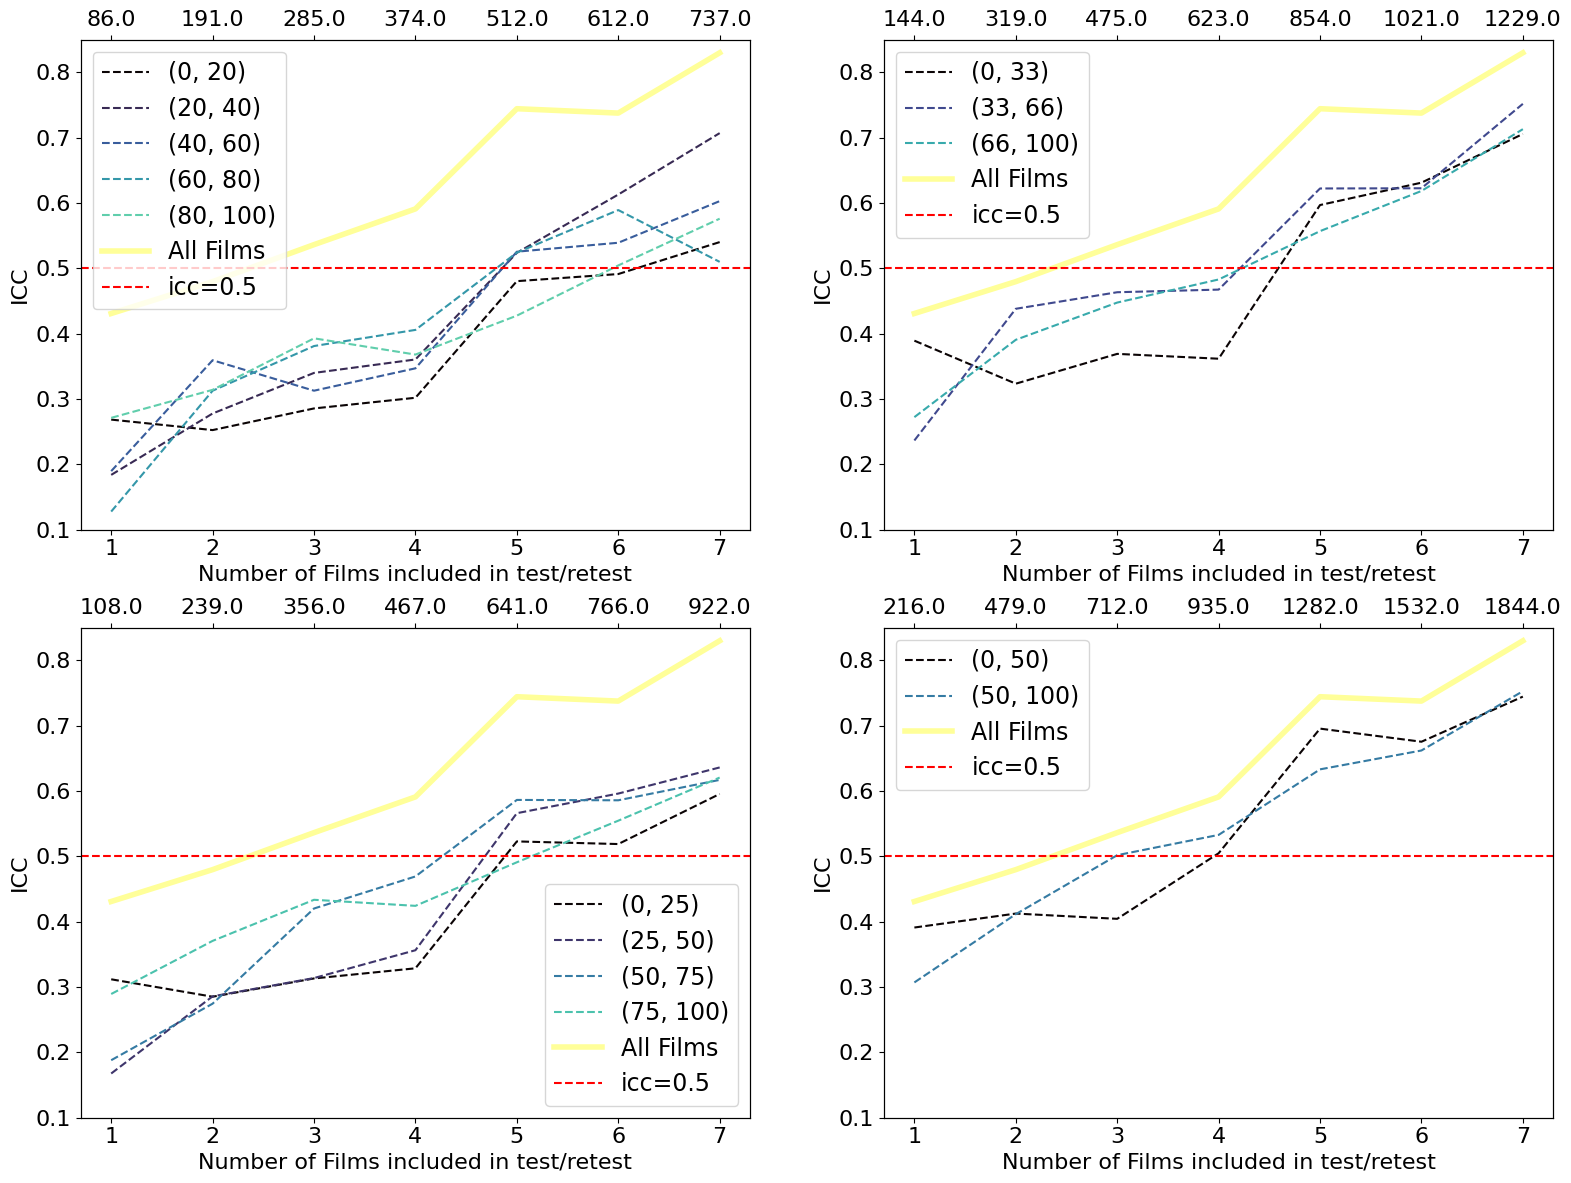

In [53]:
def tick_function(X):
    V = 1/(1+X)
    return ["%.3f" % z for z in V]

cm = plt.get_cmap('mako')


icc_bounds = per_fa[1]
fig,ax = plt.subplots(2,2, figsize=(19,14))
for idx,bounds in enumerate([s20, s25, s33, s50]):
    r,c = idx%2, idx//2
    NUM_COLORS = len(bounds)

    ax[r,c].set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
    for k in range(len(bounds)):
        ax[r,c].plot(np.asarray([icc_bounds[s] for s in bounds]).mean(axis=-1)[k],
                linestyle='--', label='{}'.format(bounds[k]), )

    ax[r,c].plot(np.asarray(step_iccfull).mean(axis=1), label='All Films', 
                 color=sns.color_palette("Paired")[10], linewidth=4.0)
    ax[r,c].axhline(y=0.5, color='r', linestyle='--', label='icc=0.5')

    ax[r,c].legend(prop={'size':17})

    ax2 = ax[r,c].twiny()
    ax2.set_xlim(ax[r,c].get_xlim())
    ax2.set_xticks(np.arange(0,7))
    ax2.set_xticklabels(avg//NUM_COLORS, fontsize=16)
    
    ax[r,c].set_xlabel('Number of Films included in test/retest', fontsize=16)
#     ax[r,c].set_ylabel('icc single | absolute agree | random factor')
    ax[r,c].set_ylabel('ICC', fontsize=16)
    ax[r,c].set_xticklabels(np.arange(0,8), fontsize=16)
    ax[r,c].set_ylim(0.1,0.85)
    ax[r,c].set_yticklabels(np.arange(1,9)/10,fontsize=16)



In [ ]:
# save('icc_score.pkl',per_fa)

#### Visualize Parcel-wise ICC on cortical-subcortical displays

In [ ]:
per_fa = load('./resources/test_retest_logs/icc_score.pkl')
icc_full = load('./resources/test_retest_logs/fullmovie_icc.pkl')

icc_bounds = np.asarray([per_fa[2][bound][-1] for bound in s25])
movie_icc = icc_full[-1]

In [ ]:
# Parcellation 400
labeling         = load_parcellation('schaefer', scale=400, join=True)
surf_lh, surf_rh = load_conte69()

mask = labeling != 0
gs   = icc_bounds.tolist() + [movie_icc]

bounds = (0, 1)
grad = [None] * 5
for i in range(5):
        # map the gradient to the parcels
        grad[i] = map_to_labels(np.array(gs[i][:400]), labeling, mask=mask, fill=np.nan)

texts = [str(s[0])+'_'+str(s[1]) for s in s25] + ['full']
paths = ['../figures/test_retest_fig/icc_{}.jpg'.format(str(s[0])+'_'+str(s[1])) for s in s25] + ['../figures/test_retest_fig/icc_full.jpg']
for k in range(5):
        genpath = paths[k]
        plot_hemispheres(surf_lh, surf_rh, array_name=[grad[k]], size=(600, 500), cmap='hot', layout_style="grid",
                        color_bar=True, label_text=[texts[k]], zoom=1.3, embed_nb=True, interactive=False, screenshot=True, filename=genpath,
                        transparent_bg=False, color_range=bounds)

In [ ]:
from enigmatoolbox.plotting import plot_subcortical
with open('./data/labels/TC_sub14_labels.csv') as f:
    text = f.readlines()
    text = [t.strip() for t in text]

order = "left-accumbens, left-amygdala, left-caudate, left-hippocampus, left-pallidum, left-putamen, left-thalamus, right-accumbens, right-amygdala, right-caudate, right-hippocampus, right-pallidum, right-putamen, right-thalamus".split(',')
order = [' '.join(o.split('-')).strip() for o in order]
dataorder = [t.lower() for t in text]
orderidx = [order.index(o) for o in dataorder]

# "color-range" flag can be used if needed very useful instead of artificially
# Project the results on the surface brain
for sidx,s in enumerate(s25):
    print(paths[sidx])
    plot_subcortical(array_name=np.array(gs[sidx][400:])[orderidx], ventricles=False, size=(800, 400), color_range=bounds,
                    cmap='hot', color_bar=True, embed_nb=False, label_text=['movie sub'], interactive=False, transparent_bg=False,
                    screenshot=True, filename='../figures/test_retest_fig/subcort_icc_{}.jpg'.format(str(s[0])+'_'+str(s[1]) ),zoom=1.45)

plot_subcortical(array_name=movie_icc[400:][orderidx], ventricles=False, size=(800, 400), color_range=bounds,
                cmap='hot', color_bar=True,embed_nb=False, label_text=['movie sub'], interactive=False,transparent_bg=False,
                screenshot=True, filename='../figures/test_retest_fig/subcort_icc_full.jpg',zoom=1.45)

### Discriminality

In [55]:
per_fa_dis = {}
for fa_nb in range(3):
    dis_bounds = {}
    for bound in tqdm(thresholds):
        fselected_series = f_series[fa_nb][bound]

        step_array = []
        for k in range(1,len(set1)+1):
            # Grouping test-retest
            fselect1_gradients = persubject_grad(fselected_series,set1[:k])
            fselect2_gradients = persubject_grad(fselected_series,set2[:k])
            samples = np.array(list(fselect1_gradients.values()) + list(fselect2_gradients.values()))

            dis_array = compute_discriminality(samples)
            step_array.append(dis_array)

        dis_bounds[bound] = step_array
    per_fa_dis[fa_nb] = dis_bounds

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

In [53]:
step_disfull = []
for k in range(1,len(set1)+1):
    # Grouping test-retest
    ftotal1_gradients = persubject_grad(total_series,set1[:k])
    ftotal2_gradients = persubject_grad(total_series,set2[:k])
    samples = np.array(list(ftotal1_gradients.values()) + list(ftotal2_gradients.values()))
    
    dis_fullarray = compute_discriminality(samples)
    step_disfull.append(dis_fullarray)

In [56]:
# save('./resources/test_retest_logs/fullmovie_dis.pkl',np.asarray(step_disfull))
# save('./resources/test_retest_logs/dis_score.pkl',per_fa_dis)

In [54]:
per_fa_dis = load('./resources/test_retest_logs/dis_score.pkl')
step_disfull = load('./resources/test_retest_logs/fullmovie_dis.pkl')

dis_bounds = np.asarray([per_fa[2][bound][-1] for bound in s25])
movie_dis = step_disfull[-1]

#### Visualize results

/tmp/ipykernel_169353/2251125330.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[idx,0].set_xticklabels(np.arange(0,8))


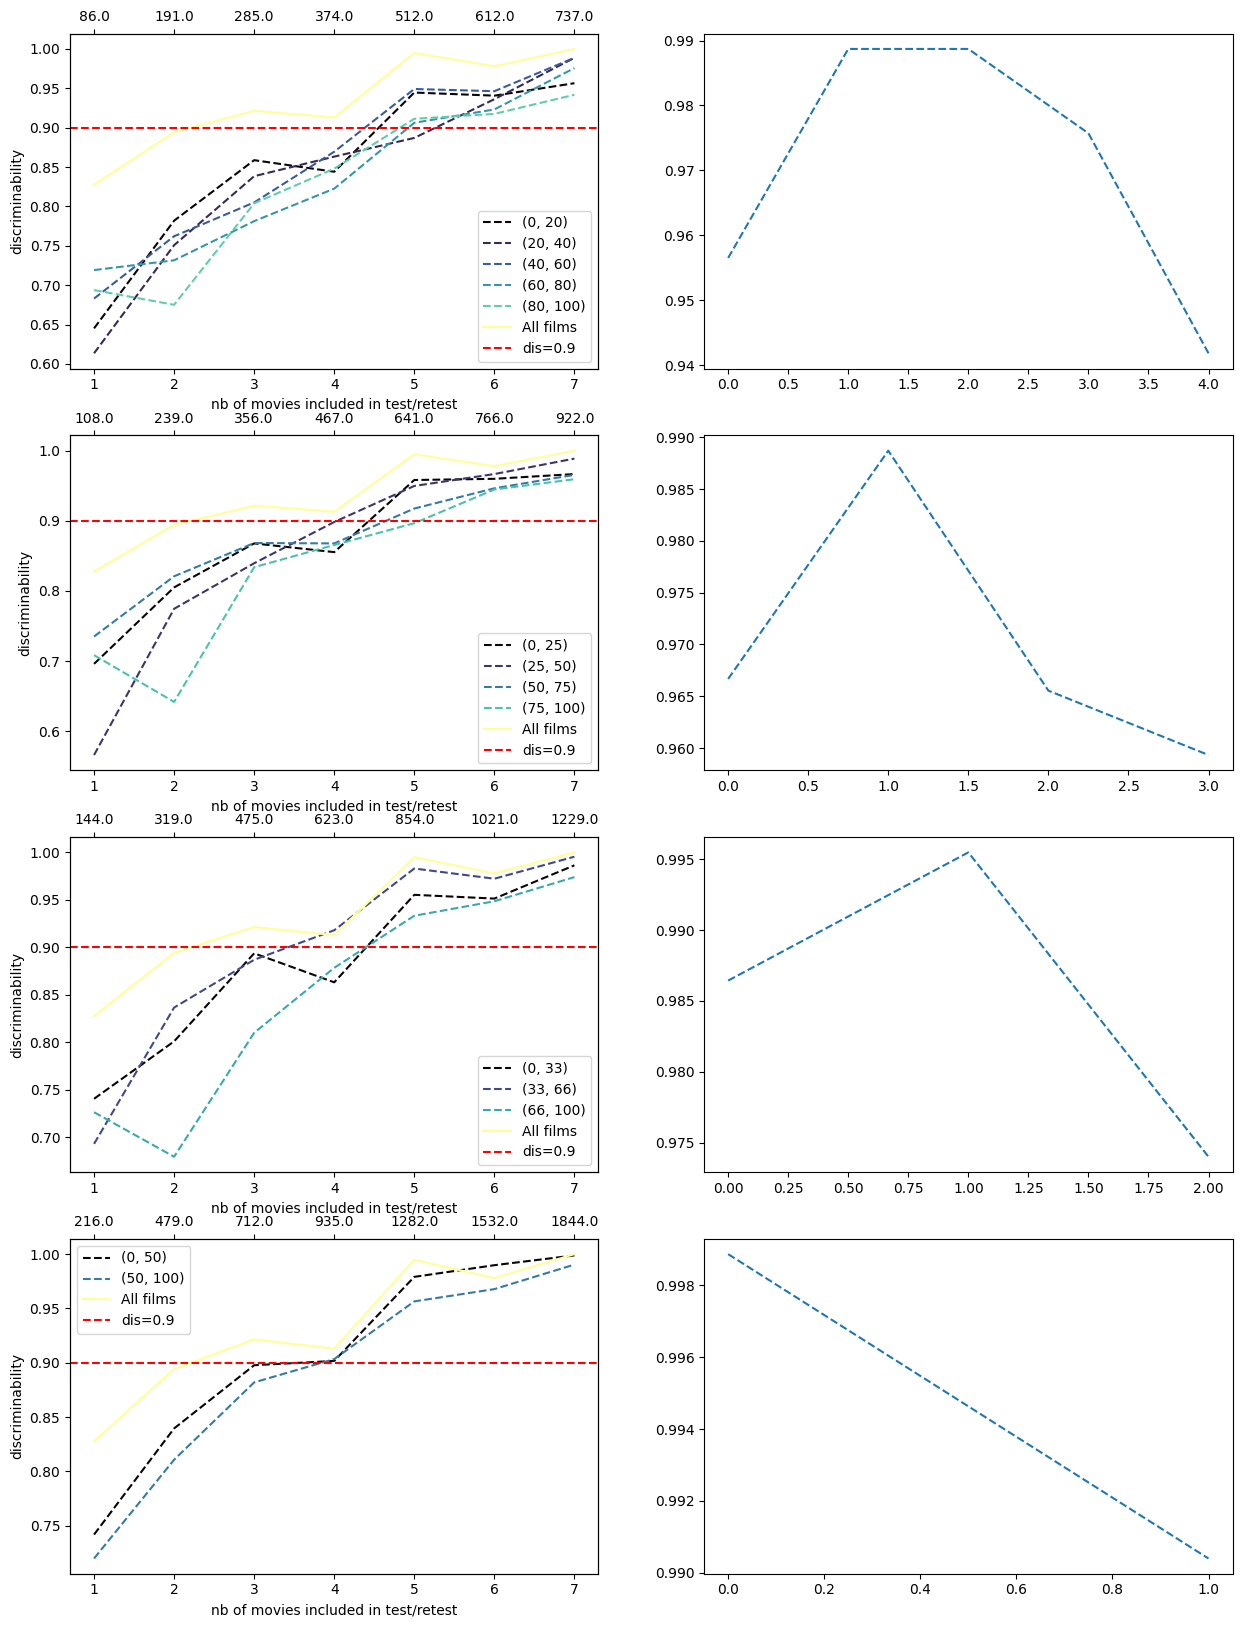

In [58]:
cm = plt.get_cmap('mako')

dis_bounds = per_fa_dis[1]
fig, ax = plt.subplots(4,2,figsize=(15,20))
for idx,bounds in enumerate([s20, s25, s33, s50]):
    NUM_COLORS = len(bounds)
    ax[idx,0].set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
    
    for k in range(len(bounds)):
        ax[idx,0].plot(np.asarray([dis_bounds[s] for s in bounds])[k],linestyle='--', label=bounds[k])
    
    ax[idx,0].plot(np.asarray(step_disfull), label='All films', color=sns.color_palette("Paired")[10])
    ax[idx,0].axhline(y=0.9, color='r', linestyle='--', label='dis=0.9')
    ax[idx,1].plot(np.asarray([dis_bounds[s][-1] for s in bounds]),linestyle='--')
    ax[idx,0].legend()
    
    ax2 = ax[idx,0].twiny()
    ax2.set_xlim(ax[idx,0].get_xlim())
    ax2.set_xticks(np.arange(0,7))
    ax2.set_xticklabels(avg//NUM_COLORS)
    

    ax[idx,0].set_xlabel("nb of movies included in test/retest")
    ax[idx,0].set_ylabel("discriminability")
    ax[idx,0].set_xticklabels(np.arange(0,8))    

Visual explanation of what discriminality is

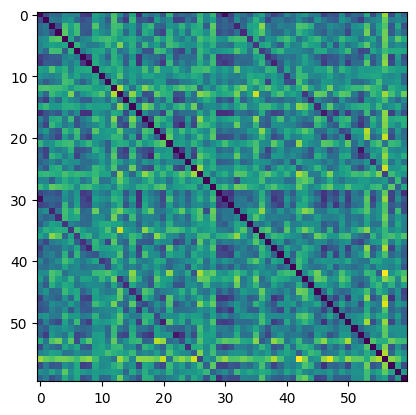

In [50]:
plt.imshow(dist_mat)